In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.ticker as mtick

In [4]:
import decision_trees_helper
%aimport decision_trees_helper

import class_helper
%aimport class_helper

In [5]:
# Generate plots for use in the notebook
ens_h = decision_trees_helper.Ensemble_Helper()
data = ens_h.make_iris()

ens_result = ens_h.make_ens( pairs=[ [0,2] ])
fig_submodels, axs_submodles = ens_result["individual models plot"]
fig_sum, axs_sum = ens_result["ensemble plot"]
pairs = ens_result["pairs"]

RandomForest with 30 estimators with features [0, 2] has a score of 0.9466666666666667


In [6]:
# Pick one pair, one model from the list of (pairs x models) to plot
pair_idx, model_idx = 0,0
pair = pairs[pair_idx]

ens_estimators = ens_result["estimators"][pair_idx][model_idx]
X, y = ens_result["individual model data"][pair_idx][model_idx]

fig_ens = ens_h.plot_ens(X, y, ens_estimators, feature_names=[ "$x_{i:d}$".format(i=idx+1) 
                                                              for i, idx in enumerate(pair)
                                                             ])

# Ensembles

Following our Recipe for Machine Learning, we may try out several models before deciding on the final one.

Is a single "best" model really best ? Is there an alternative ?

By combining models with independent errors, we may be able to construct a combined model
whose accuracy is better than the best individual model.

The combined models are called an *Ensemble*.

The individual models
- May be of different types: 
    - Decision Tree, Logistic Regression, KNN
- May be of the *same* type, with different parameters/hyper-parameters:
    - Decision Trees of different depths or different features
    - Regression with polynomial features of different degrees

When the individual models are of the same type
- Each individual models is trained on a *different* subset of the training examples
- This enables the individual models to produce different results
- Makes them more robust to outliers

We will shortly explain how the subsets are chosen.

Here is an Ensemble of individual models of the same type: Decision Trees

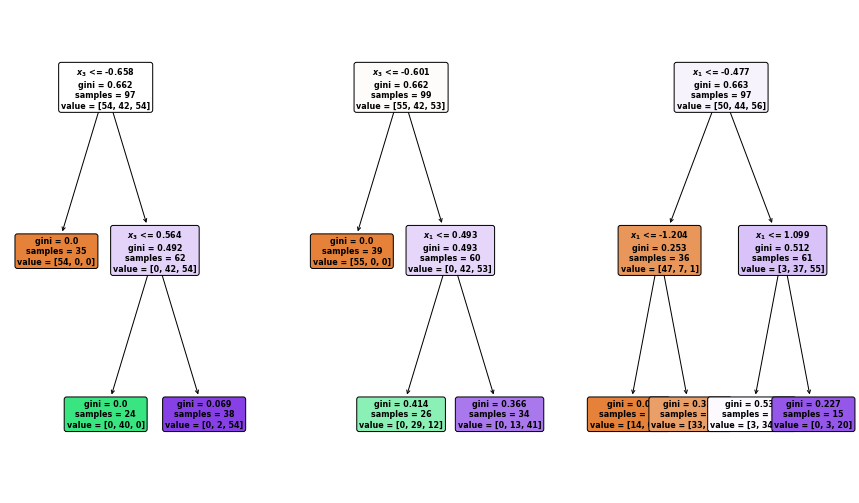

In [7]:
fig_ens

The individual models are usually quite simple and restricted.
- They are *weak learners*: accuracy only marginally better than chance
- But combine to create a *strong learner*.


If the prediction of an ensemble of $M$ binary classifiers is based on a "majority vote"
- The prediction is incorrect only if $m' \ge \ceil{M/2}$ classifiers are incorrect
- The probability of a particular set of $m'$ models of equal accuracy $A$ all being incorrect is
$
{ (1 - A)^{m'} }
$
- There are $$ \begin{pmatrix} M \\ m' \\
\end{pmatrix}
$$
combinations of $m'$ models
- So the probability of a correct ensemble prediction when $m'$ classifiers are incorrect is
$$
1- \begin{pmatrix} M \\ m' \\
\end{pmatrix} *  { (1 - A)^{m'} }
$$
which tends to $1$ as $M$ increases.

The power of Ensembles comes via the size of $M$.

Ensembling is independent of the types of the individual models
- A meta-model that can combine many different types of individual models
- Under the assumption of **independent** errors
- Often applied in competitions

 ## Ensemble prediction

Each individual model comes up with a prediction for the target $\hat{\y}^\ip$ of example $i$,
given features $\x^\ip$.

Let
$p_{\tp,c}^\ip$
- Denote the probability predicted by the $\tt^{th}$ individual classifier
- That target $\y^\ip$ is in category $c \in C$
- Given features $\x^\ip$

The class predicted by the ensemble is the one with highest average  (across individual models) probability
$$
\hat{\y}^\ip = \argmax{c}{ \sum_{\tt=1}^M} { p_{\tp,c}^\ip }
$$



Returning to the Ensemble of Decision Trees example, we can plot the decision boundary of
each individual model

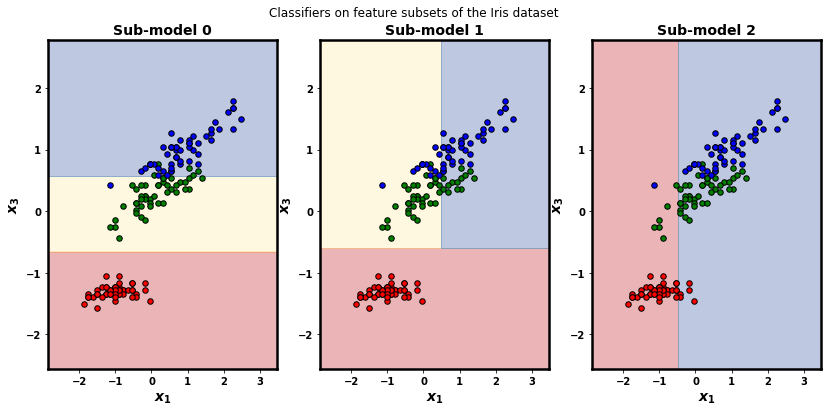

In [8]:
fig_submodels

By superimposing these boundaries on top of one another, we can visualize the "vote"


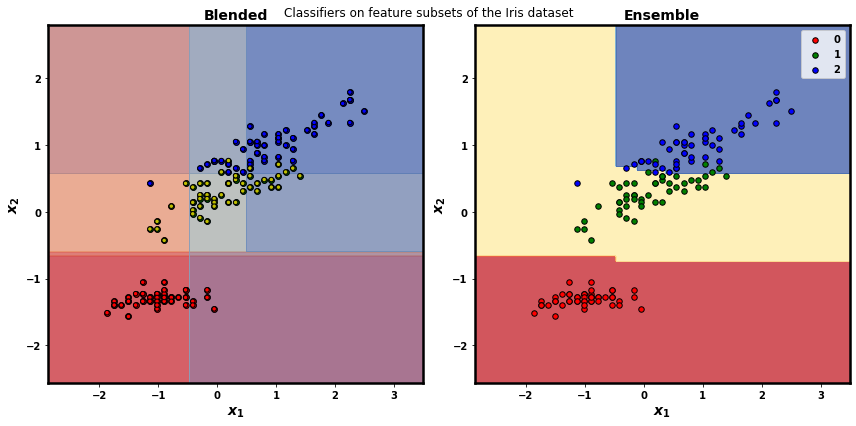

In [9]:
fig_sum

- The left plot is the super-position
- The right plot is the final boundary of the ensemble

You can see that the combination of the weak learners does a pretty good job !

# Bagging, Bootstrapping

One way to construct multiple weak learners of the *same* type of model
- Is to train each individual model on a *restricted* set of training examples

Because each individual model is trained on different examples, the predictions made by
each are hopefully somewhat independent.

Given the full set of training examples
$$ \langle \X, \y \rangle = [ \x^\ip, \y^\ip | 1 \le i \le m ]$$

we construct a restricted set of examples 
$$ \langle \X_\tp, \y_\tp \rangle $$
on which to train the $\tt^{th}$ individual model

The restricted set 
is constructed by
- Selecting $m$ examples at random from $\langle \X, \y \rangle$
- *With replacement*
- So it is possible for an example $i'$ to appear more than once in $ \langle \X_\tp, \y_\tp \rangle$

This process is called *bootstrapping* and results in
- $ \langle \X_\tp, \y_\tp \rangle = [ \x^{(i')}, \y^{(i')} | i' \in \{ i_1, \ldots, i_m \} ] $
- Where $i_1, \ldots, i_m$ are the indices of the $m$ chosen examples


If each of the $m$ examples in $ \langle \X, \y \rangle$ is chosen with equal probability $\frac{1}{m}$
- The probability of a particular example $i$ **not** being in $ \langle \X_\tp, \y_\tp \rangle$ is
$$
( 1 - \frac{1}{m} )^m
$$

In [10]:
m = np.arange(50, 1000, 50)
p = (1 - 1/m)**m


fig, ax = plt.subplots(1,1, figsize=(12,6))
_= ax.plot(m, p)
_= ax.set_xlabel("m")
_= ax.set_ylabel("prob not in bootstrapped sample")
_= ax.set_yticklabels( [ "{:.2%}".format(y) for y in p])
plt.close(fig)

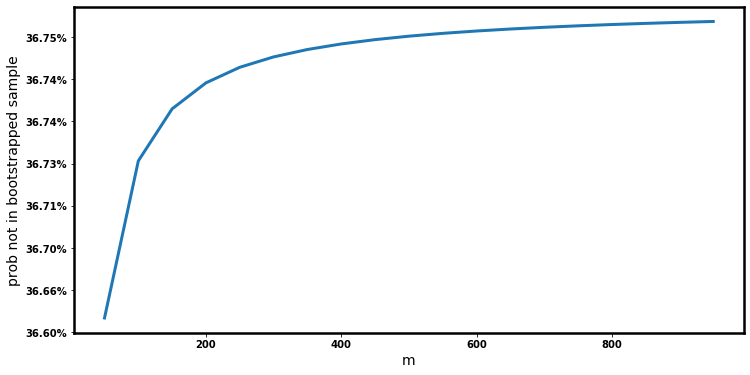

In [11]:
fig

Thus about 63% of the examples in the bootstrapped set are duplicates.

The weak learner can't overfit to any example that is not in its training set.

The process of
- Bootstrapping restricted training examples
- Training individual models on the bootstrapped examples
- Aggregating model predictions into a single prediction

is called *bagging* and each individual training set is called a bag

Bagging has a nice side-effect
- About 37% of the full set of examples are not present in a given bag
- Called *out of bag*

The out of bag examples thus can be used to test out of sample prediction !

# Random Forests

A Random Forest
- Is a collection of Decision Trees
- Of restricted power (weak learners)
- Created by Bagging


The learners are made weak by
- Training on a bootstrapped subset
- By limiting the depth of the Decision Tree
- By limiting the choice of feature on which to split a node
    - To a random subset of all features
    
The result is that the individual models (Decision Trees) are relatively independent.

# Boosting

There is another approach to creating ensembles of weak learners.

The method is called *boosting*
- Rather than create weak learners independently, i.e., a *set*
- Boosting creates a *sequence* of weak learners: $M_{(0)}, M_{(1)}, \ldots, M_{(M)}$
- Where the $(\tt +1)^{th}$ individual model in the sequence
- Focuses on correctly predicting those examples *incorrectly* predicted by the $\tt^{th}$ individual model

**Notation**

We will be dealing with many sequences.  We use subscripts in parentheses to index elements of a sequence.
$$M_{(0)}, M_{(1)}, \ldots, M_{(M)}$$

<table>
    <tr>
        <center><strong>Bagging</strong></center>
    </tr>
    <br><br>
<img src=images/Bagging.png>
</table>

<table>
    <tr>
        <center><strong>Boosting</strong></center>
    </tr>
    <br><br><br><br>
<img src=images/Boosting.png>
</table>

How do we get an individual model to focus on some particular examples ?
- By assigning each example a weight
- Increasing the probability that more heavily weighted examples are included in the training examples for the model

Let $\text{say}_\tp^\ip$ denote the weight assigned to example $i$ in the training set for the $\tt^{th}$
individual model

The "say" is adjusted from the $\tt^{th}$ model to the $(\tt+1)^{th}$ individual model

$
\begin{array}[lll]\\
\text{If example } i \text{ is incorrectly predicted in model } \tt: & \text{say}_{(\tt+1)}^\ip > \text{say}_\tp^\ip \\
\text{If example } i \text{ is correctly predicted in model } \tt: & \text{say}_{(\tt+1)}^\ip <\text{say}_\tp^\ip \\
\end{array}
$


When bootstrapping, rather than drawing examples with equal probability
- Draw examples for model $(\tt +1)$ in proportion to it's $\text{say}_{(\tt+1)}^\ip$
- So examples that were "problematic" in model $\tt$ are over-represented in training model $(\tt+1)$

- Boosting creates a collection of "specialists" (focus on hard to predict examples)
- Bagging creates a collection of "generalists", each a little better than random

## AdaBoost

AdaBoost is a particular model that uses boosting
- The individual models are Decision Trees
    - Usually depth $1$; "stumps"
- There is an "importance" associated with each individual model 
- Models with higher weight have a greater impact on ensemble prediction


Let
$$\text{importance}_\tp$$ 
denote the weight of the $\tt^{th}$ individual model in the sequence.

- $\text{importance}_\tp$ is determined by the Performance Metric (e.g., Accuracy) of individual model $\tt$

- The class predicted by the ensemble is the one with highest *importance-weighted* average  (across individual models) probability
$$
\hat{\y}^\ip = \argmax{c}{ \sum_{\tt=1}^M} { ( p_{\tp,c}^\ip * \text{importance}_\tp)}
$$

Thus, models that are more successful have greater weight.

# Gradient Boosting

Gradient Boosting is a "more mathematical" (less operational) approach to boosting
- A Loss Function is defined
- That measures the Loss $\loss_\tp$ of the ensemble consisting of the first $\tt$ models in the sequence
- Computes the gradient of the Loss $\loss_\tp$
- Adds model $(\tt +1)$ to explicitly reduce the loss by moving in the direction of the gradient
$$
\loss_{(\tt+1)} < \loss_\tp
$$


We illustrate Gradient Boosting with a Regression task: predict continuous $\hat{\y}$
- We will produce a sequence of models $M_{(0)}, M_{(1)}, \ldots, M_{(M)}$


We have not specified the functional form of the models $M_\tt$
- It will typically be something like a Decision Tree and *not* Linear Regression

Model $\tt$ will have 
- Target denoted by $e_\tp$
- Predictions denoted by $\hat{e}_\tp$
- We define $\hat{e}_{(0)} = \bar{\y}$
    - where $\bar{\y}$ is the mean (over the $m$ examples in training) of the target
$$
\bar{\y} = \frac{1}{m} \sum_{i=1}^m { \y^\ip }
$$

The prediction of the *ensemble* (rather than individual models) consisting of the first $\tt$ models is 
$$
\hat{\y}_\tp = \sum_{\tt'=0}^\tt { \alpha * \hat{e}_\tp }
$$

That is: the *ensemble prediction* is the weighted sum of the *predictions of the individual models*.
- Unlike AdaBoost: the weights for each model are identical ($\alpha$)

**Loss function**

The Loss function for the ensemble consisting of the first $\tt$ models will be the MSE:
$$\loss_\tp = \frac{1}{m} \sum_{i=1}^m { (\y^\ip - \hat{\y}_\tp ^\ip)^2}$$

The ensemble prediction $\hat{\y}_\tp$ differs from the regression target $\y$ by
$$
\y - \hat{\y}_\tp = \e_{(\tt + 1)}
$$

We therefore set the target for model $(\tt+1)$
- To be $\e_{(\tt + 1)}$
- Which is the *residual* (error) of the target with respect to the ensemble prediction up to step $\tt$

In other words: model $(\tt +1)$ is tasked with predicting the residual remaining after the
ensemble prediction of the first $\tt$ individual models.

To be clear, let's suppose the $M_\tp$ are Decision Trees.
- Each tree $M_\tp$ is constructed from *scratch*
    - It does not "extend" tree $M_{(\tt-1)}$
- It's thus possible that two trees in the sequence have the same test  
- Each tree $M_\tp$ has a different target
    - The target for $M_\tp$ is the remaining error between target $\y$ and the prediction of the ensemble prefix of length $(\tt -1)$



- Because we defined $\e_{(0)} = \bar{\y}$
    - $\e_{(1)} = \y - \bar{\y}$

- So model $M_{(1)}$ is trying to predict the residual with respect to a simpler model (one that always predicts $\bar{\y})$

- The ensemble of length $1$ predicts
$$
\bar{\y} + \hat{e}_{(1)}
$$

Each model $\tt$ in the sequence attempts to reduce the residual left over from the
ensemble prediction of the prefix of length $(\tt-1)$.

## Where are the gradients in Gradient Boosting ?

Consider the derivative of the Loss function (MSE) with respect to the ensemble prediction
$$
\begin{array}[lll]\\
\frac{\partial \loss_\tp}{\partial \hat{\y}_\tt} & = & \frac{\partial \frac{1}{m} \sum_{i=1}^m { (\y^\ip - \hat{\y}_\tp) ^\ip)^2}}{\partial \hat{\y}_\tt} \\
& = & \frac{2}{m}  (\y^\ip - \hat{\y}_\tp ^\ip) * -1 & \text{chain rule} \\
& = &  - \frac{2}{m}  \e_{(\tt + 1)} & \text{definition of } \e_{(\tt + 1)} \\
\end{array}
$$

That is: the gradient is proportional to the residual of the target with respect to the 
the prediction of the ensemble consisting of the first $\tt$ models

You shouldn't be surprised to see the residual in the gradient; this is just a fact of the MSE
- It's derivative is closely related to the residual
- One can argue that the MSE was *chosen* exactly because of this property

So the ensemble of $(\tt+1)$ models can decrease the loss compared
to the ensemble with $\tt$ models
$$
\loss_{(\tt+1)} < \loss_\tp
$$
by making $\hat{\y}_{(\tt+1)}$ equal to
$\hat{\y}_\tp$ plus the approximation of the residual.

This process of 
- Minimizing a Loss function
- By incrementally updating predictions
    - In the direction (opposite direction really, because gradient is negative) the gradient
is called *Gradient Descent*.

Gradient Descent 
- Will be our prime method of solving optimization problems, such as training models (minimizing Loss)
- Is a key component of Deep Learning

We will explore Gradient Descent in a subsequent module.

**Aside**

Even though AdaBoost was created prior to Gradient Boosting
- It can be shown to be equivalent to Gradient Boosting when the Loss function is Exponential Loss.

In [12]:
print("Done")

Done
